# Dropout Placement Analysis in ResNet for CIFAR-100

This notebook trains ResNet-18 models on CIFAR-100 with four different dropout placements:
1. Standard (after ReLU)
2. Pre-ReLU (before activation)
3. Post-Addition (after skip connection)
4. Mixed (pre-ReLU + post-addition)

We evaluate Top-1/Top-5 accuracy, loss curves, calibration (ECE), and Hessian-based flatness.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.ops import DropBlock2d
import random

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Model definitions

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, out_planes, stride=1, dropout_rate=0.3, variant='standard', downsample=None, dropblock_size=5, sd_prob=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, out_planes, stride)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.conv2 = conv3x3(out_planes, out_planes)
        self.bn2   = nn.BatchNorm2d(out_planes)
        #self.downsample = downsample
        #self.dropout_rate = dropout_rate
        #self.variant = variant
        self.variant      = variant.lower()
        self.dropout_rate = dropout_rate
        self.sd_prob      = sd_prob

        # SpatialDropout2d
        if self.variant == 'spatial':
            self.drop_fn = nn.Dropout2d(p=dropout_rate)
        else:
            self.drop_fn = None

        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        if self.variant in ['pre-relu', 'mixed']:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = F.relu(out)
        if self.variant == 'standard':
            out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        
        if self.variant == 'stochastic-depth' and self.training:
            if random.random() < self.sd_prob:
                out = torch.zeros_like(out)
            else:
                out = out / (1 - self.sd_prob)
        
        out += identity
        if self.variant in ['post-addition', 'mixed']:
            out = F.dropout(out, p=self.dropout_rate, training=self.training)

        if self.variant in ('spatial') and self.drop_fn is not None:
            out = self.drop_fn(out)
        
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100, dropout_rate=0.3, variant='standard'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(self.in_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1, dropout_rate=dropout_rate, variant=variant)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate, variant=variant)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, out_planes, blocks, stride, dropout_rate, variant):
        downsample = None
        if stride != 1 or self.in_planes != out_planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, out_planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes * block.expansion),
            )
        layers = [block(self.in_planes, out_planes, stride, dropout_rate, variant, downsample)]
        self.in_planes = out_planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, out_planes, 1, dropout_rate, variant))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def create_resnet18(variant):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=100, dropout_rate=0.3, variant=variant).to(device)

In [3]:
# Dataset and DataLoader

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.CIFAR100('./data', train=True, download=True, transform=train_transform)
test_set  = torchvision.datasets.CIFAR100('./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training and Evaluation Loop

import time
from collections import defaultdict

variants = ['spatial', 'stochastic-depth']
results = {}

for var in variants:
    print(f"Training variant: {var}")
    model = create_resnet18(var)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50,75], gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    history = defaultdict(list)
    for epoch in range(1, 61):
        # Training
        model.train()
        running_loss = 0.0
        correct1 = 0; correct5 = 0; total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, pred = outputs.topk(5, 1)
            total += targets.size(0)
            correct1 += (pred[:,0] == targets).sum().item()
            correct5 += sum([1 for i in range(targets.size(0)) if targets[i].item() in pred[i].tolist()])
        train_loss = running_loss / total
        train_acc1 = correct1 / total * 100
        train_acc5 = correct5 / total * 100
        # Evaluation
        model.eval()
        running_loss = 0.0
        correct1 = 0; correct5 = 0; total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
                _, pred = outputs.topk(5, 1)
                total += targets.size(0)
                correct1 += (pred[:,0] == targets).sum().item()
                correct5 += sum([1 for i in range(targets.size(0)) if targets[i].item() in pred[i].tolist()])
        test_loss = running_loss / total
        test_acc1 = correct1 / total * 100
        test_acc5 = correct5 / total * 100
        scheduler.step()
        # Log
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc1'].append(train_acc1)
        history['train_acc5'].append(train_acc5)
        history['test_loss'].append(test_loss)
        history['test_acc1'].append(test_acc1)
        history['test_acc5'].append(test_acc5)
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}: Test Top1={test_acc1:.2f}%")
    results[var] = history

Training variant: spatial
Epoch 1: Test Top1=5.50%
Epoch 10: Test Top1=27.95%
Epoch 20: Test Top1=40.92%
Epoch 30: Test Top1=42.98%
Epoch 40: Test Top1=47.65%
Epoch 50: Test Top1=47.09%
Epoch 60: Test Top1=62.02%
Training variant: stochastic-depth
Epoch 1: Test Top1=11.20%
Epoch 10: Test Top1=50.76%
Epoch 20: Test Top1=55.69%
Epoch 30: Test Top1=58.15%
Epoch 40: Test Top1=56.36%
Epoch 50: Test Top1=55.48%
Epoch 60: Test Top1=74.72%


In [5]:
for var in variants:
    print(var)
    for i in ['epoch', 'train_loss', 'train_acc1', 'train_acc5', 'test_loss', 'test_acc1', 'test_acc5']:
        print(i)
        print(results[var][i])
    print()

spatial
epoch
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
train_loss
[4.513414986572266, 4.0883780975341795, 3.8760144232940674, 3.7318677671813965, 3.613542807006836, 3.5145487297058104, 3.4278874144744873, 3.3461623269653322, 3.2623389221954344, 3.18525627243042, 3.102385177612305, 3.0340134098815916, 2.962795989456177, 2.8922826365661622, 2.8443291773223875, 2.786891585845947, 2.722130037307739, 2.6735429420471193, 2.634542019958496, 2.599945241394043, 2.5602456267547606, 2.517845631866455, 2.501567914428711, 2.471150100784302, 2.4473865156555177, 2.427548119049072, 2.4124393940734863, 2.39165763633728, 2.3797188110351564, 2.363877635498047, 2.3511449927520753, 2.329755506286621, 2.315157409515381, 2.3134393448638915, 2.3006317880249023, 2.2830408782196043, 2.277010384521484, 2.2629473234558106, 2.

In [6]:
for var in variants:
    print(var)
    for i in ['epoch', 'train_loss', 'train_acc1', 'train_acc5', 'test_loss', 'test_acc1', 'test_acc5']:
        print(i)
        print(results[var][i][50:61])
    print()

spatial
epoch
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
train_loss
[1.841387830810547, 1.6787715936660768, 1.621661975517273, 1.5707921975708008, 1.5195980319595337, 1.486367591896057, 1.4663120068740845, 1.4370563995361327, 1.405083878097534, 1.3843408420562744]
train_acc1
[50.544, 54.054, 55.518, 56.474000000000004, 57.786, 58.69799999999999, 58.964000000000006, 59.848, 60.314, 60.878]
train_acc5
[80.348, 82.994, 83.89, 84.636, 85.612, 86.076, 86.494, 86.726, 87.324, 87.736]
test_loss
[1.5222227313995362, 1.4776814476013183, 1.447150735282898, 1.4242643224716187, 1.3987406784057617, 1.387562907409668, 1.36349386138916, 1.3662952354431153, 1.3512083423614503, 1.3436301380157472]
test_acc1
[57.48, 58.699999999999996, 59.589999999999996, 60.309999999999995, 60.4, 60.45, 61.45, 61.68, 61.82, 62.019999999999996]
test_acc5
[85.53, 85.71, 86.36, 86.56, 86.92, 87.16000000000001, 87.45, 87.37, 87.64999999999999, 87.77000000000001]

stochastic-depth
epoch
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60

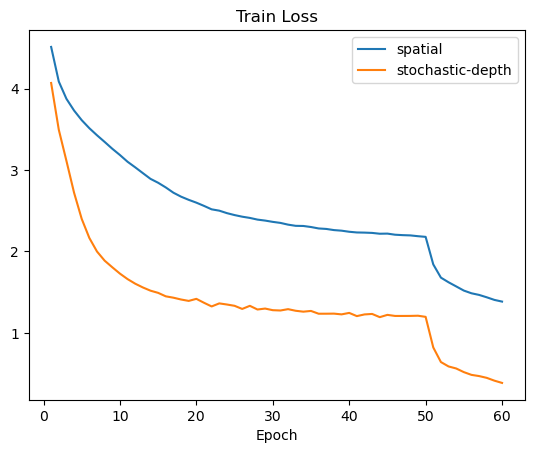

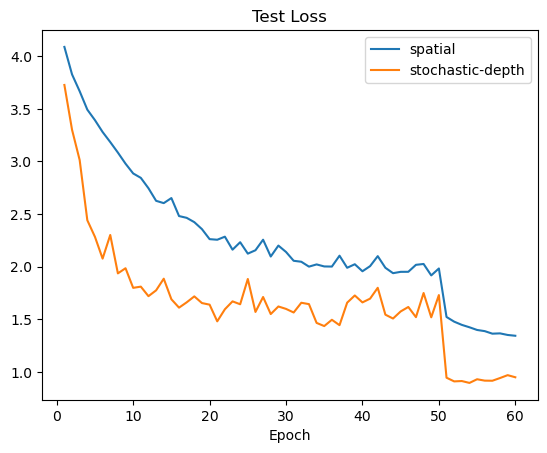

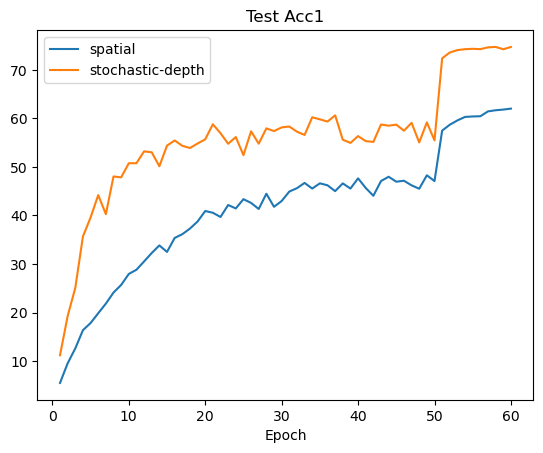

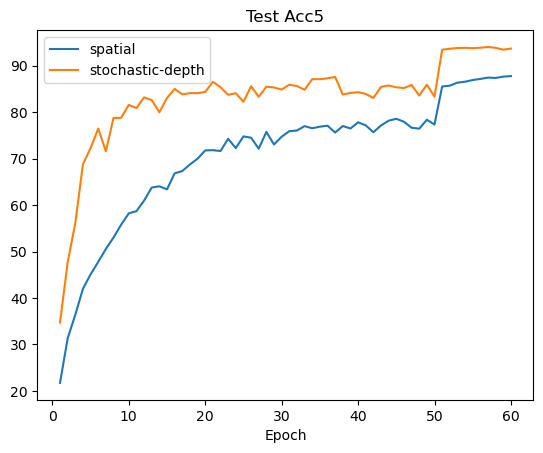

In [7]:
# Plotting Results

for metric in ['train_loss', 'test_loss', 'test_acc1', 'test_acc5']:
    plt.figure()
    for var in variants:
        plt.plot(results[var]['epoch'], results[var][metric], label=var)
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

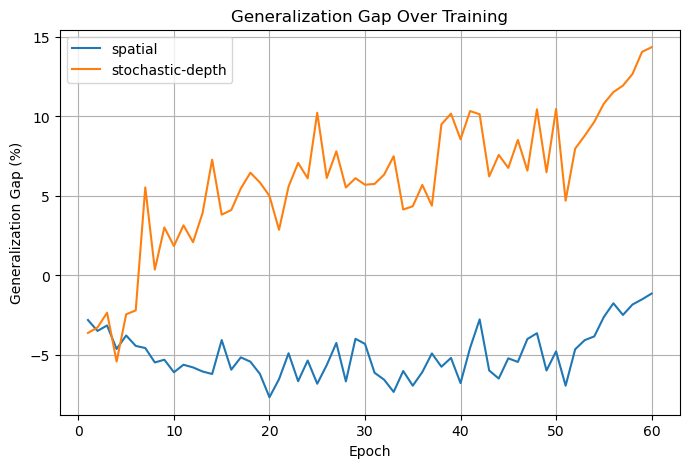

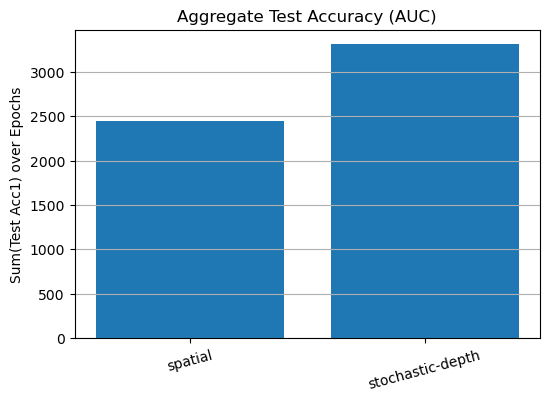

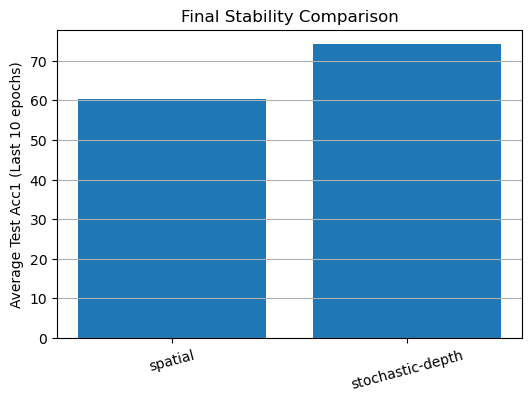

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `results` is a dict mapping variant name to its history dict, e.g.:
# results = {
#     'standard': {'epoch': [...], 'train_acc1': [...], 'test_acc1': [...], ...},
#     'pre-relu': {...},
#     'post-addition': {...},
#     'mixed': {...}
# }

variants = ['spatial', 'stochastic-depth']

# 1) Generalization Gap: train_acc1 - test_acc1 over epochs
plt.figure(figsize=(8,5))
for var in variants:
    hist = results[var]
    gap = np.array(hist['train_acc1']) - np.array(hist['test_acc1'])
    plt.plot(hist['epoch'], gap, label=var)
plt.xlabel('Epoch')
plt.ylabel('Generalization Gap (%)')
plt.title('Generalization Gap Over Training')
plt.legend()
plt.grid(True)
plt.show()

# 2) Aggregate Test Accuracy (Area Under Curve)
auc_scores = {}
for var in variants:
    hist = results[var]
    auc_scores[var] = np.trapz(hist['test_acc1'], hist['epoch'])  # approximate integral

plt.figure(figsize=(6,4))
plt.bar(auc_scores.keys(), auc_scores.values())
plt.ylabel('Sum(Test Acc1) over Epochs')
plt.title('Aggregate Test Accuracy (AUC)')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

# 3) Stability: Average Test Acc1 over last 10 epochs
avg_last10 = {}
for var in variants:
    hist = results[var]
    avg_last10[var] = np.mean(hist['test_acc1'][-10:])

plt.figure(figsize=(6,4))
plt.bar(avg_last10.keys(), avg_last10.values())
plt.ylabel('Average Test Acc1 (Last 10 epochs)')
plt.title('Final Stability Comparison')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()
